# This is a code designed to use two ML models, Non deep learning model and deep learning model, perform end to end modeling process

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR


In [2]:
# load datasets
mat = pd.read_csv('student-mat.csv',sep=';')
por = pd.read_csv('student-por.csv',sep=';')




# Create a master database
masterDatabase = pd.concat([mat, por], axis=0, ignore_index=True)
print(masterDatabase.shape)
print(masterDatabase.isnull().sum())

(1044, 33)
school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64


## This part is for feature engineering

In [3]:
print(masterDatabase.columns)


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')


In [4]:
# Classify pass or fail based on G3
masterDatabase['pass'] = masterDatabase['G3'].apply(lambda x: 1 if x >= 10 else 0)

# Dropping G1 G2 and G3 columns
masterDatabase.drop(['G1', 'G2', 'G3'], axis=1, inplace=True)
print(masterDatabase.head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  internet romantic  famrel  freetime  goout Dalc Walc health absences pass  
0       no       no       4         3      4    1    1      3        6    0  
1      yes       no       5         3      3    1    1      3        4    0  
2      yes       no       4         3      2    2    3      3       10    1  
3      yes      yes       3         2      2    1    1      5        2    1  
4       no       no       4         3      2    1    2      5        4    1  

[5 rows x 31 columns]


In [5]:
# One-hot encoding for all catagorical columns

categorical_cols = masterDatabase.select_dtypes(include='object').columns.tolist()

df_encoded = pd.get_dummies(masterDatabase, columns=categorical_cols, drop_first=True)


In [6]:
print(df_encoded.head())
print(df_encoded.shape)

   age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  goout  \
0   18     4     4           2          2         0       4         3      4   
1   17     1     1           1          2         0       5         3      3   
2   15     1     1           1          2         3       4         3      2   
3   15     4     2           1          3         0       3         2      2   
4   16     3     3           1          2         0       4         3      2   

   Dalc  ...  guardian_mother  guardian_other  schoolsup_yes  famsup_yes  \
0     1  ...             True           False           True       False   
1     1  ...            False           False          False        True   
2     2  ...             True           False           True       False   
3     1  ...             True           False          False        True   
4     1  ...            False           False          False        True   

   paid_yes  activities_yes  nursery_yes  higher_yes  internet

In [7]:
# Split into training and test datasets and apply scale
X = df_encoded.drop('pass', axis=1)
y = df_encoded['pass']

# Split dataset for 80% for training set and 20% for testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale dataset
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Logistic Regression

Best C:0.01
Best CV:10
Best Cross-Validated Accuracy: 0.8179


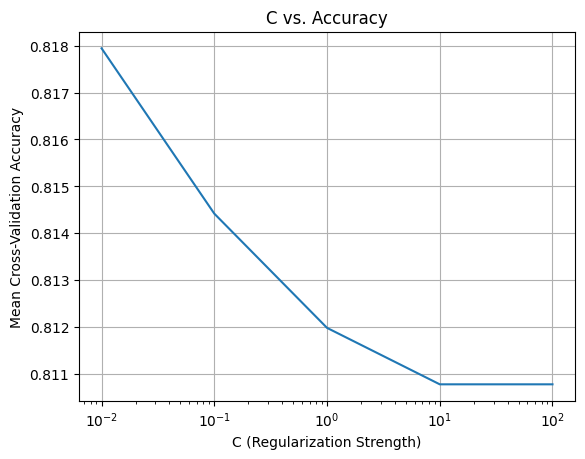

In [8]:
# nested loop for finding the best values for c and cv
C_values = [0.01, 0.1, 1, 10, 100]
cv_values = [3, 5, 10]

best_score = 0
best_c = 0.0
best_cv = 0

for c in C_values:
    for cv in cv_values:
        model = LogisticRegression(C=c, penalty='l2', solver='lbfgs', max_iter=1000)
        scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_c = c
            best_cv = cv

print("Best C:{:.2f}".format(best_c))
print("Best CV:{}".format(best_cv))
print("Best Cross-Validated Accuracy: {:.4f}".format(best_score))

scores_list = []

for c in C_values:
    model = LogisticRegression(C=c, penalty='l2', solver='lbfgs', max_iter=1000)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='accuracy')
    scores_list.append(scores.mean())

plt.plot(C_values, scores_list)
plt.xscale('log')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('C vs. Accuracy')
plt.grid(True)
plt.show()


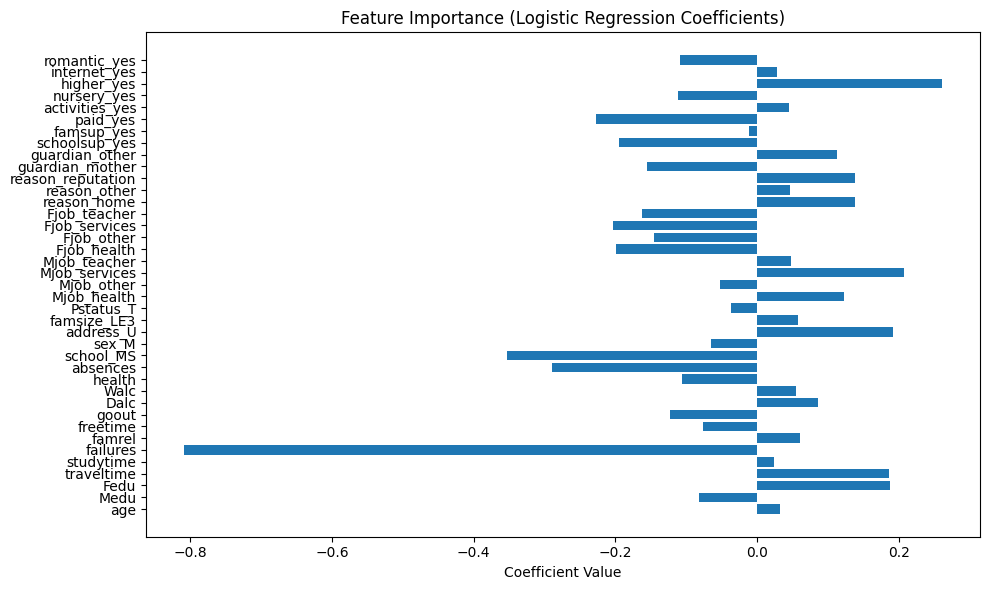

In [17]:
#This code is designed to check feature importance
# Train logistic regression
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

# Get coefficients
feature_importance = log_model.coef_[0]
feature_names = X_train_scaled.columns 

# Plot
plt.figure(figsize=(10,6))
plt.barh(feature_names, feature_importance)
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

## Deep Learning

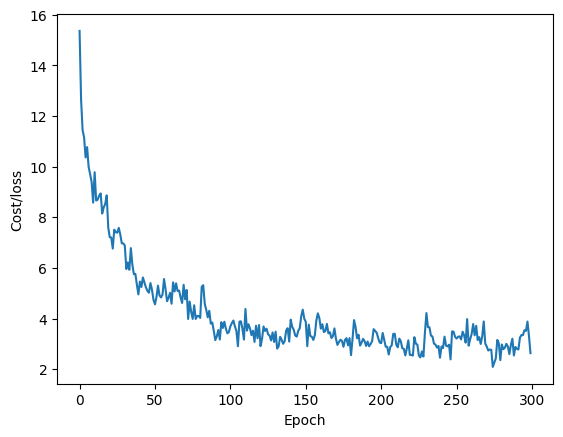

In [27]:
# Set random seeds
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

# Convert training and test data to TensorDatasets
trainset = TensorDataset(torch.from_numpy(X_train_scaled.to_numpy()).float(), 
                         torch.from_numpy(y_train.to_numpy()).float())
testset = TensorDataset(torch.from_numpy(X_test_scaled.to_numpy()).float(), 
                        torch.from_numpy(y_test.to_numpy()).float())

# Create Dataloaders for our training and test data to allow us to iterate over minibatches 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

class FeedForwardNet(nn.Module):
    def __init__(self, n_input, n_hidden1, n_hidden2, n_output):
        super().__init__()
        self.hidden1 = nn.Linear(n_input, n_hidden1)
        self.dropout1 = nn.Dropout(0.3)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.dropout2 = nn.Dropout(0.3)
        self.out = nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout1(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.out(x))
        return x
    
    # Instantiate our neural network
net = FeedForwardNet(n_input=X_train_scaled.shape[1], n_hidden1=40, n_hidden2=15, n_output=1)

# Define the cost / loss function
cost_fn = nn.BCELoss()

# Define the method of updating the weights each iteration (e.g. gradient descent)
optimizer = optim.Adam(net.parameters(), lr=0.005,weight_decay = 1e-3)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_iter = 300
cost = []

net = net.to(device)
net.train() # Set the model to training mode

for epoch in range(num_iter):

    running_loss = 0.0
    
    for i, data in enumerate(trainloader):
        
        # Get the inputs X and labels y for the minibatch
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the gradients of the weights each iteration
        optimizer.zero_grad()

        # Calculate the predictions and the cost/loss
        outputs = net(inputs).view(-1)
        loss = cost_fn(outputs, labels)
        
        # Use autograd to calculate the gradient of the cost with respect to each weight
        loss.backward()
        
        # Use the optimizer to do the weights update
        optimizer.step()

        # Define a step down after 100 epoch
        scheduler = StepLR(optimizer, step_size=100, gamma=0.01)

        # Store the cost/loss
        running_loss += loss.item()
        
    cost.append(running_loss)
        
plt.plot(cost)
plt.xlabel('Epoch')
plt.ylabel('Cost/loss')
plt.show()

In [28]:
net.eval()
with torch.no_grad():
    y_pred = net(torch.from_numpy(X_test_scaled.to_numpy()).float().to(device)).view(-1)
    y_pred_class = (y_pred > 0.5).float().cpu().numpy()
    accuracy = accuracy_score(y_test, y_pred_class)
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7225


## Model Optimization Process

I tried different model settings to improve the accuracy and make training more stable. 

First, I used learning rate 0.01, Adam optimizer, and hidden layer sizes (40, 15). The test accuracy was 0.7033.

Then I changed the learning rate to 0.1 and increased the hidden layer size to (40, 20). The accuracy improved to 0.7129, but I saw many spikes in the cost/loss curve. It means the training was not very stable. I think the learning rate was too high.

Next, I used learning rate 0.005, and it worked well at the beginning. But after 100 epochs, the cost/loss started to go up and down again. 

So I added a step-down scheduler, which changed the learning rate to 0.001 after 100 epochs. This helped make the training more stable, and test accuracy increased to 0.7321.

After that, I wanted to stop overfitting and make the model generalize better. I added dropout layers after the first and second hidden layers, with dropout rate 0.3. After adding dropout, the accuracy became 0.7225. Even though the accuracy was a little lower, the loss curve was more smooth and stable.

In the end, I learned that tuning learning rate, adding scheduler, and dropout can help improve the model. The final model has good balance between accuracy and stability.
